<a href="https://colab.research.google.com/github/PeKkaPie95/GenAI-Creative-Text-and-Image-Generation/blob/GANS_/FCandDCgansMNISTipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8cvnb472
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8cvnb472
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # Importing Datasets
# (28*28*1) - Here 1 represents the channels 1-Greyscale, 3-RGB.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshaping into (No. Of Images,28,28,1) and converting to flaot32
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


BUFFER_SIZE = 60000
BATCH_SIZE = 256


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

'**First Implementation of FCGANs**

In [ ]:
def fcgan_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(256, input_dim=100, activation='relu'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


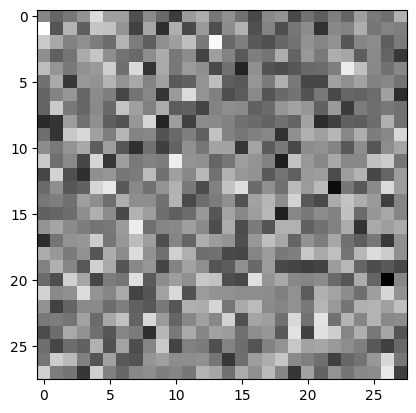

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = fcgan_generator()(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def fcgan_discriminator():
    model = models.Sequential()

    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
discriminator = fcgan_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5080773]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Implementing a suitable optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Define constants
LATENT_DIM = 100
BATCH_SIZE = 256
BUFFER_SIZE = 60000
EPOCHS = 100

In [ ]:
@tf.function
# Defining the trainig step function
def train_step(real_images, discriminator, generator, cross_entropy, generator_optimizer, discriminator_optimizer):
    batch_size = real_images.shape[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Calculate gradients and apply them
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# And this is the tarining loop
def train_fcgan(dataset, epochs):
    generator = fcgan_generator()
    discriminator = fcgan_discriminator()

    for epoch in range(epochs):
        for real_images in dataset:
            gen_loss, disc_loss = train_step(real_images, discriminator, generator, cross_entropy, generator_optimizer, discriminator_optimizer)

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

        # Generate and plot images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_plot(generator)


In [ ]:
# This is the function which generates and plots images
def generate_and_plot(generator):
    noise = tf.random.normal([16, LATENT_DIM])
    generated_images = generator(noise, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 4.416332244873047, Disc Loss: 0.14639338850975037
Epoch 2, Gen Loss: 8.200645446777344, Disc Loss: 0.004878472536802292
Epoch 3, Gen Loss: 8.216018676757812, Disc Loss: 0.04132135212421417
Epoch 4, Gen Loss: 7.872237682342529, Disc Loss: 0.26541733741760254
Epoch 5, Gen Loss: 6.871523857116699, Disc Loss: 0.06229336932301521
Epoch 6, Gen Loss: 5.731517791748047, Disc Loss: 0.2414913773536682
Epoch 7, Gen Loss: 3.1768341064453125, Disc Loss: 0.7083998918533325
Epoch 8, Gen Loss: 2.971986770629883, Disc Loss: 0.4622500538825989
Epoch 9, Gen Loss: 2.177645683288574, Disc Loss: 0.44296130537986755
Epoch 10, Gen Loss: 3.8794829845428467, Disc Loss: 0.15773507952690125


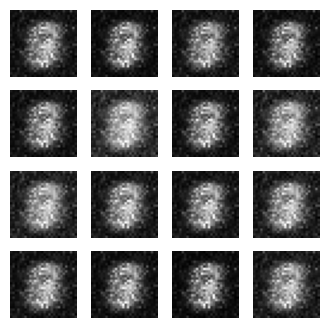

Epoch 11, Gen Loss: 4.309646129608154, Disc Loss: 0.056767821311950684
Epoch 12, Gen Loss: 7.299369812011719, Disc Loss: 0.3019998073577881
Epoch 13, Gen Loss: 5.039187908172607, Disc Loss: 0.09439271688461304
Epoch 14, Gen Loss: 6.4161577224731445, Disc Loss: 0.06566061079502106
Epoch 15, Gen Loss: 5.9308576583862305, Disc Loss: 0.055137909948825836
Epoch 16, Gen Loss: 7.256858825683594, Disc Loss: 0.014812508597970009
Epoch 17, Gen Loss: 7.44197940826416, Disc Loss: 0.11857514828443527
Epoch 18, Gen Loss: 6.251725196838379, Disc Loss: 0.35323962569236755
Epoch 19, Gen Loss: 5.950350761413574, Disc Loss: 0.08765088766813278
Epoch 20, Gen Loss: 5.6225690841674805, Disc Loss: 0.06953926384449005


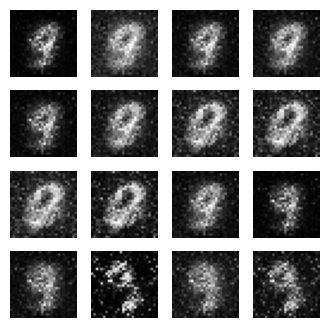

Epoch 21, Gen Loss: 5.330426216125488, Disc Loss: 0.11130491644144058
Epoch 22, Gen Loss: 6.442992210388184, Disc Loss: 0.22486670315265656
Epoch 23, Gen Loss: 4.507360935211182, Disc Loss: 0.13329681754112244
Epoch 24, Gen Loss: 5.5273895263671875, Disc Loss: 0.15679918229579926
Epoch 25, Gen Loss: 6.479033470153809, Disc Loss: 0.23584148287773132
Epoch 26, Gen Loss: 4.61151647567749, Disc Loss: 0.3182803690433502
Epoch 27, Gen Loss: 4.493501663208008, Disc Loss: 0.2860192060470581
Epoch 28, Gen Loss: 5.870936393737793, Disc Loss: 0.15028229355812073
Epoch 29, Gen Loss: 4.315994739532471, Disc Loss: 0.25863027572631836
Epoch 30, Gen Loss: 5.397319316864014, Disc Loss: 0.14283421635627747


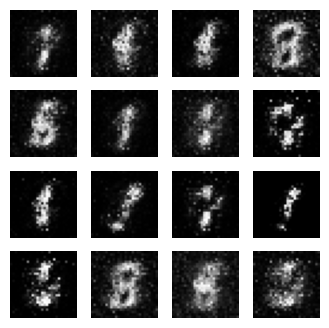

Epoch 31, Gen Loss: 4.753374099731445, Disc Loss: 0.2624891996383667
Epoch 32, Gen Loss: 4.614358901977539, Disc Loss: 0.15315911173820496
Epoch 33, Gen Loss: 4.608377456665039, Disc Loss: 0.2940107583999634
Epoch 34, Gen Loss: 4.364803314208984, Disc Loss: 0.3206794857978821
Epoch 35, Gen Loss: 3.219484329223633, Disc Loss: 0.3499492406845093
Epoch 36, Gen Loss: 4.031892776489258, Disc Loss: 0.25005292892456055
Epoch 37, Gen Loss: 3.8039615154266357, Disc Loss: 0.5084331035614014
Epoch 38, Gen Loss: 3.91200590133667, Disc Loss: 0.29394981265068054
Epoch 39, Gen Loss: 4.298698425292969, Disc Loss: 0.40682730078697205
Epoch 40, Gen Loss: 4.314419269561768, Disc Loss: 0.32442334294319153


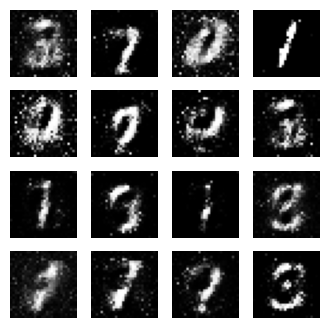

Epoch 41, Gen Loss: 4.527036666870117, Disc Loss: 0.31646811962127686
Epoch 42, Gen Loss: 3.734177350997925, Disc Loss: 0.2851331830024719
Epoch 43, Gen Loss: 3.6558456420898438, Disc Loss: 0.33606666326522827
Epoch 44, Gen Loss: 3.3962912559509277, Disc Loss: 0.3157132565975189
Epoch 45, Gen Loss: 3.550076961517334, Disc Loss: 0.326725035905838
Epoch 46, Gen Loss: 3.1514220237731934, Disc Loss: 0.48883065581321716
Epoch 47, Gen Loss: 2.8598718643188477, Disc Loss: 0.3790566325187683
Epoch 48, Gen Loss: 2.878824234008789, Disc Loss: 0.412598192691803
Epoch 49, Gen Loss: 2.7553038597106934, Disc Loss: 0.4926033318042755
Epoch 50, Gen Loss: 2.916065216064453, Disc Loss: 0.4838619530200958


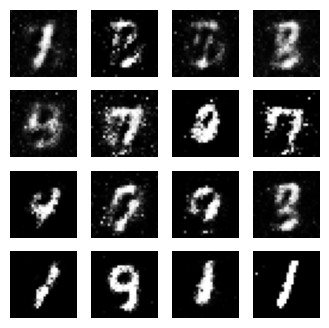

Epoch 51, Gen Loss: 3.0704991817474365, Disc Loss: 0.5963209867477417
Epoch 52, Gen Loss: 2.667717695236206, Disc Loss: 0.3923293948173523
Epoch 53, Gen Loss: 4.2980546951293945, Disc Loss: 0.41560542583465576
Epoch 54, Gen Loss: 3.2668685913085938, Disc Loss: 0.5249447226524353
Epoch 55, Gen Loss: 2.923409938812256, Disc Loss: 0.49922657012939453
Epoch 56, Gen Loss: 2.383551597595215, Disc Loss: 0.5385105013847351
Epoch 57, Gen Loss: 2.589226484298706, Disc Loss: 0.6603055596351624
Epoch 58, Gen Loss: 3.4304232597351074, Disc Loss: 0.4703105390071869
Epoch 59, Gen Loss: 2.3346147537231445, Disc Loss: 0.6235954761505127
Epoch 60, Gen Loss: 2.073122262954712, Disc Loss: 0.4823336601257324


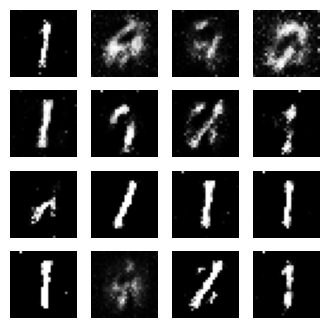

Epoch 61, Gen Loss: 2.567808151245117, Disc Loss: 0.5700993537902832
Epoch 62, Gen Loss: 2.770230770111084, Disc Loss: 0.5472947359085083
Epoch 63, Gen Loss: 2.201108932495117, Disc Loss: 0.5692139863967896
Epoch 64, Gen Loss: 2.885404109954834, Disc Loss: 0.5126066207885742
Epoch 65, Gen Loss: 3.1838250160217285, Disc Loss: 0.42682573199272156
Epoch 66, Gen Loss: 2.9497153759002686, Disc Loss: 0.6188375949859619
Epoch 67, Gen Loss: 2.0636963844299316, Disc Loss: 0.734053373336792
Epoch 68, Gen Loss: 3.527529716491699, Disc Loss: 0.5313255786895752
Epoch 69, Gen Loss: 3.205369710922241, Disc Loss: 0.5353939533233643
Epoch 70, Gen Loss: 2.321233034133911, Disc Loss: 0.6217200756072998


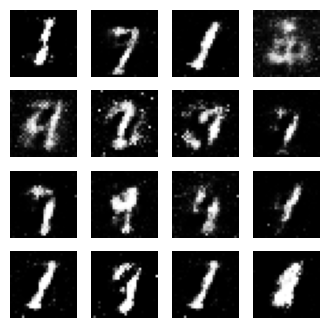

Epoch 71, Gen Loss: 2.144456624984741, Disc Loss: 0.6255855560302734
Epoch 72, Gen Loss: 2.9567487239837646, Disc Loss: 0.47334110736846924
Epoch 73, Gen Loss: 2.499077558517456, Disc Loss: 0.6694839596748352
Epoch 74, Gen Loss: 2.5440917015075684, Disc Loss: 0.5001287460327148
Epoch 75, Gen Loss: 2.393726110458374, Disc Loss: 0.545545220375061
Epoch 76, Gen Loss: 1.580396056175232, Disc Loss: 0.8893673419952393
Epoch 77, Gen Loss: 2.058043956756592, Disc Loss: 0.7342092394828796
Epoch 78, Gen Loss: 2.052826166152954, Disc Loss: 0.6960709095001221
Epoch 79, Gen Loss: 2.1219723224639893, Disc Loss: 0.6747782230377197
Epoch 80, Gen Loss: 2.7469823360443115, Disc Loss: 0.4043211042881012


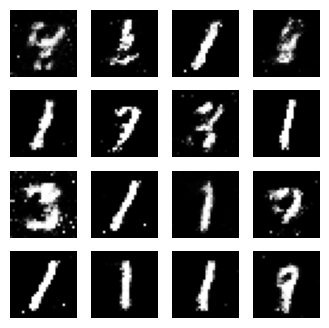

Epoch 81, Gen Loss: 2.361246347427368, Disc Loss: 0.4388049244880676
Epoch 82, Gen Loss: 2.6898179054260254, Disc Loss: 0.7410984039306641
Epoch 83, Gen Loss: 1.9383068084716797, Disc Loss: 0.6571289896965027
Epoch 84, Gen Loss: 2.282325506210327, Disc Loss: 0.6346360445022583
Epoch 85, Gen Loss: 2.666267156600952, Disc Loss: 0.7179319262504578
Epoch 86, Gen Loss: 1.9176664352416992, Disc Loss: 0.6889088153839111
Epoch 87, Gen Loss: 2.071399450302124, Disc Loss: 0.8840129375457764
Epoch 88, Gen Loss: 1.7078231573104858, Disc Loss: 0.9093755483627319
Epoch 89, Gen Loss: 2.146714210510254, Disc Loss: 0.793389081954956
Epoch 90, Gen Loss: 1.6782554388046265, Disc Loss: 0.8462011218070984


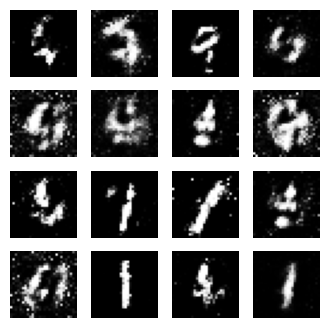

Epoch 91, Gen Loss: 2.0322253704071045, Disc Loss: 0.5910958647727966
Epoch 92, Gen Loss: 1.444082260131836, Disc Loss: 0.8286914825439453
Epoch 93, Gen Loss: 1.4915354251861572, Disc Loss: 0.8776901960372925
Epoch 94, Gen Loss: 1.9080989360809326, Disc Loss: 0.7826918363571167
Epoch 95, Gen Loss: 1.6601998805999756, Disc Loss: 0.7738404273986816
Epoch 96, Gen Loss: 1.4126501083374023, Disc Loss: 0.9369887113571167
Epoch 97, Gen Loss: 1.8971389532089233, Disc Loss: 0.5666549205780029
Epoch 98, Gen Loss: 1.6520484685897827, Disc Loss: 0.8775050640106201
Epoch 99, Gen Loss: 1.9350312948226929, Disc Loss: 0.7203969955444336
Epoch 100, Gen Loss: 1.977335810661316, Disc Loss: 1.1360645294189453


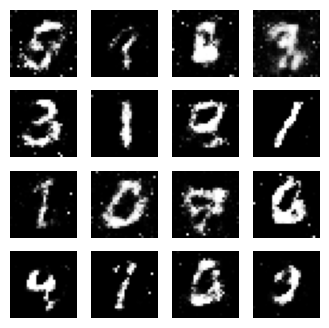

In [ ]:
# FIRE!! Full speed ahead
# Start the training
train_fcgan(train_dataset, EPOCHS)


**Now DCGANs**

In [ ]:
# Generator model (DCGAN)
def dcgan_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False))
    return model

# Discriminator model (DCGAN)
def dcgan_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [ ]:
# Similar to previous defining loss and optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
# Define the training step function for DCGAN
@tf.function
def train_step(real_images, discriminator, generator, cross_entropy, generator_optimizer, discriminator_optimizer):
    batch_size = real_images.shape[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Calculate gradients and apply them
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# Define the training loop for DCGAN
def train_dcgan(dataset, epochs):
    generator = dcgan_generator()
    discriminator = dcgan_discriminator()

    for epoch in range(epochs):
        for real_images in dataset:
            gen_loss, disc_loss = train_step(real_images, discriminator, generator, cross_entropy, generator_optimizer, discriminator_optimizer)

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

        # Generate and plot images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_plot(generator)


In [ ]:
# Function to generate and plot images

def generate_and_plot(generator):
    noise = tf.random.normal([16, LATENT_DIM])  # Generate random noise
    generated_images = generator(noise, training=False)  # Generate images from noise
    plt.figure(figsize=(4, 4))  # Create a 4x4 grid for the generated images
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Gen Loss: 1.165551781654358, Disc Loss: 0.6936562061309814
Epoch 2, Gen Loss: 1.4903199672698975, Disc Loss: 0.6010153293609619
Epoch 3, Gen Loss: 1.209333062171936, Disc Loss: 1.128645420074463
Epoch 4, Gen Loss: 2.0844078063964844, Disc Loss: 0.7346769571304321
Epoch 5, Gen Loss: 1.5764811038970947, Disc Loss: 0.8424379229545593
Epoch 6, Gen Loss: 1.1663812398910522, Disc Loss: 1.112119436264038
Epoch 7, Gen Loss: 1.588773488998413, Disc Loss: 0.7659968137741089
Epoch 8, Gen Loss: 1.0239496231079102, Disc Loss: 1.3169585466384888
Epoch 9, Gen Loss: 1.3288933038711548, Disc Loss: 0.931136965751648
Epoch 10, Gen Loss: 1.3722000122070312, Disc Loss: 0.956580638885498


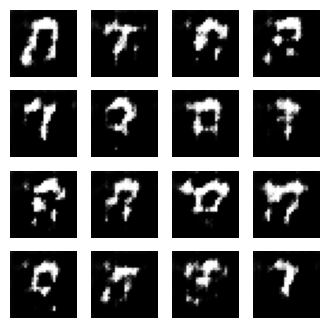

Epoch 11, Gen Loss: 1.611703634262085, Disc Loss: 0.6096110343933105
Epoch 12, Gen Loss: 1.3418382406234741, Disc Loss: 0.8626545071601868
Epoch 13, Gen Loss: 0.8737376928329468, Disc Loss: 1.323874831199646
Epoch 14, Gen Loss: 1.1887315511703491, Disc Loss: 1.1723897457122803
Epoch 15, Gen Loss: 1.1308890581130981, Disc Loss: 1.229363203048706
Epoch 16, Gen Loss: 0.9682668447494507, Disc Loss: 1.2273303270339966
Epoch 17, Gen Loss: 1.2058048248291016, Disc Loss: 0.9577219486236572
Epoch 18, Gen Loss: 1.3431538343429565, Disc Loss: 0.9809291362762451
Epoch 19, Gen Loss: 1.0520517826080322, Disc Loss: 1.1048526763916016
Epoch 20, Gen Loss: 1.1763672828674316, Disc Loss: 0.9128259420394897


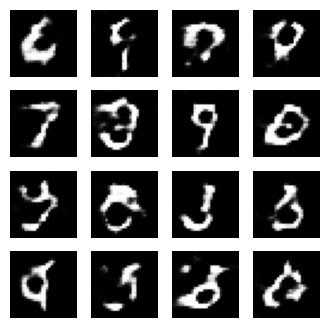

Epoch 21, Gen Loss: 1.0522606372833252, Disc Loss: 1.1044670343399048
Epoch 22, Gen Loss: 1.1359267234802246, Disc Loss: 1.109849452972412
Epoch 23, Gen Loss: 0.9997844696044922, Disc Loss: 1.2946727275848389
Epoch 24, Gen Loss: 1.1991329193115234, Disc Loss: 0.9972631931304932
Epoch 25, Gen Loss: 1.0005717277526855, Disc Loss: 1.0410304069519043
Epoch 26, Gen Loss: 1.0622766017913818, Disc Loss: 1.1440489292144775
Epoch 27, Gen Loss: 0.9864954352378845, Disc Loss: 1.1720349788665771
Epoch 28, Gen Loss: 0.8864995241165161, Disc Loss: 1.3591313362121582
Epoch 29, Gen Loss: 0.8733498454093933, Disc Loss: 1.1858748197555542
Epoch 30, Gen Loss: 0.8889634013175964, Disc Loss: 1.1805894374847412


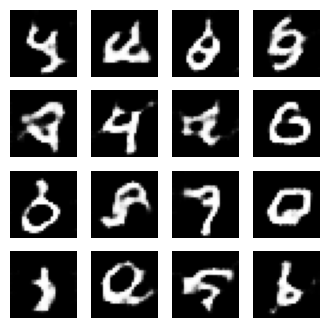

Epoch 31, Gen Loss: 0.7877492904663086, Disc Loss: 1.4083049297332764
Epoch 32, Gen Loss: 1.0566126108169556, Disc Loss: 1.1047576665878296
Epoch 33, Gen Loss: 0.923020601272583, Disc Loss: 1.1785502433776855
Epoch 34, Gen Loss: 1.0045086145401, Disc Loss: 1.1855218410491943
Epoch 35, Gen Loss: 0.8429945707321167, Disc Loss: 1.227766513824463
Epoch 36, Gen Loss: 0.8277871608734131, Disc Loss: 1.2828693389892578
Epoch 37, Gen Loss: 0.9252141714096069, Disc Loss: 1.1872901916503906
Epoch 38, Gen Loss: 1.0793790817260742, Disc Loss: 1.1763052940368652
Epoch 39, Gen Loss: 0.8763552904129028, Disc Loss: 1.3096699714660645
Epoch 40, Gen Loss: 0.8612613081932068, Disc Loss: 1.2146025896072388


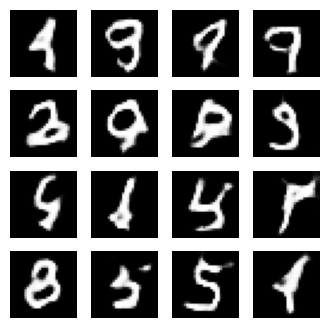

Epoch 41, Gen Loss: 0.924829363822937, Disc Loss: 1.160496473312378
Epoch 42, Gen Loss: 0.96846604347229, Disc Loss: 1.1243822574615479
Epoch 43, Gen Loss: 0.9901090860366821, Disc Loss: 1.0808396339416504
Epoch 44, Gen Loss: 0.7927440404891968, Disc Loss: 1.4050252437591553
Epoch 45, Gen Loss: 0.7940853834152222, Disc Loss: 1.4885715246200562
Epoch 46, Gen Loss: 0.6602723598480225, Disc Loss: 1.4743530750274658
Epoch 47, Gen Loss: 0.9992555379867554, Disc Loss: 1.1667014360427856
Epoch 48, Gen Loss: 0.9222113490104675, Disc Loss: 1.1240712404251099
Epoch 49, Gen Loss: 0.9280182123184204, Disc Loss: 1.2274084091186523
Epoch 50, Gen Loss: 0.8303811550140381, Disc Loss: 1.346037745475769


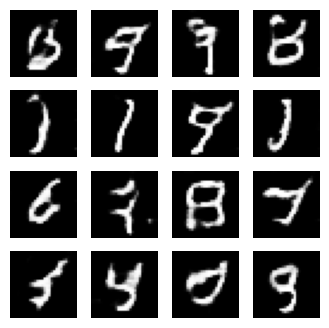

In [ ]:
# Train DC-GAN

# Start the training
train_dcgan(train_dataset, epochs=50)
